In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [2]:
#Chargement du dataset
df = pd.read_csv("Dataset_Abandon_Scolaire.csv")  


In [3]:
print("Aperçu des données :")
display(df.head())

Aperçu des données :


,Age,Sexe,Taux_presence,Nombre_retards,Note_moyenne,Situation_familiale,Abandon
0,21,Femme,89.585023,2,15.826896,Enfants à charge,0
1,20,Homme,70.713068,3,12.829358,Célibataire,0
2,22,Femme,82.122963,1,13.086319,Enfants à charge,0
3,24,Homme,87.408859,3,14.992032,Célibataire,0
4,20,Homme,86.470676,3,12.671649,Marié,0


In [4]:
print("\n Informations sur les colonnes :")
df.info()


 Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  2000 non-null   int64  
 1   Sexe                 2000 non-null   object 
 2   Taux_presence        2000 non-null   float64
 3   Nombre_retards       2000 non-null   int64  
 4   Note_moyenne         2000 non-null   float64
 5   Situation_familiale  2000 non-null   object 
 6   Abandon              2000 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 109.5+ KB


^^^

Ce jeu de données contient 2000 observations et 7 variables. Les types de données sont variés :

3 colonnes numériques entières (Age, Nombre_retards, Abandon)

2 colonnes numériques à virgule flottante (Taux_presence, Note_moyenne)

2 colonnes de type objet (catégorielles) (Sexe, Situation_familiale)

Aucune valeur manquante n’est présente.

In [5]:
print("\n Statistiques descriptives :")
display(df.describe()) 


 Statistiques descriptives :


,Age,Taux_presence,Nombre_retards,Note_moyenne,Abandon
count,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000
mean,20.5930,84.637016,2.593500,13.441019,0.084000
std,2.0133,7.921973,1.788255,1.809283,0.277457
min,14.0000,59.586369,0.000000,7.615012,0.000000
25%,19.0000,79.279829,1.000000,12.268147,0.000000
50%,21.0000,84.813868,3.000000,13.470242,0.000000
75%,22.0000,90.169016,4.000000,14.688037,0.000000
max,28.0000,100.000000,9.000000,18.833574,1.000000


^^^

Ce tableau décrit les variables numériques du jeu de données :

Âge : Les étudiants ont en moyenne 20,6 ans, avec une dispersion modérée (écart-type ≈ 2 ans). L’âge varie entre 14 et 28 ans.

Taux de présence (%) : La moyenne est d’environ 84,6 %, avec un minimum de 59,6 % et un maximum de 100 %.Une bonne assiduité générale, bien que certains étudiants aient un taux relativement bas.

Nombre de retards : La moyenne est de 2,6 retards, allant de 0 à 9. La distribution semble légèrement asymétrique vers le haut, suggérant quelques cas plus problématiques.

Note moyenne : Les notes varient de 7,6 à 18,8 avec une moyenne de 13,4, ce qui est assez équilibré. La médiane est proche de la moyenne, indiquant une distribution relativement symétrique.

Abandon : La variable cible est binaire (0 ou 1), avec une moyenne de 0,084, ce qui signifie que seulement 8,4 % des étudiants ont abandonné. Cela indique un fort déséquilibre de classes à prendre en compte lors de la modélisation.

In [6]:
print("\n Valeurs manquantes par colonne :")
display(df.isnull().sum())


 Valeurs manquantes par colonne :


Age                    0
Sexe                   0
Taux_presence          0
Nombre_retards         0
Note_moyenne           0
Situation_familiale    0
Abandon                0
dtype: int64

^^^

Aucune valeur manquante n’est présente dans le jeu de données.

In [7]:
print("\n Nombre de doublons :")
print(df.duplicated().sum())


 Nombre de doublons :
0



 Distribution de la variable cible (Abandon) :


C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2088511166.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Abandon', palette='Set2')


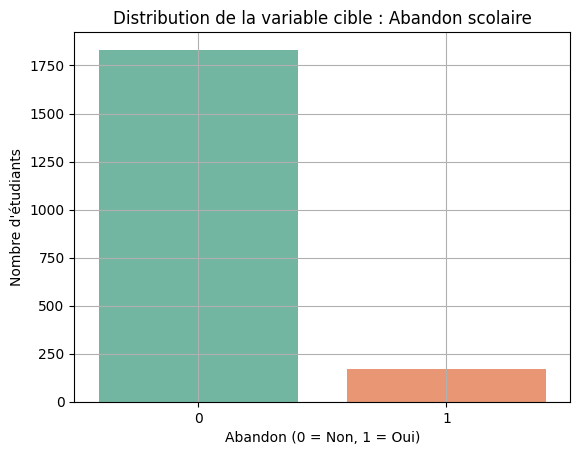

In [8]:
# Distribution de la variable cible
print("\n Distribution de la variable cible (Abandon) :")
sns.countplot(data=df, x='Abandon', palette='Set2')
plt.title("Distribution de la variable cible : Abandon scolaire")
plt.xlabel("Abandon (0 = Non, 1 = Oui)")
plt.ylabel("Nombre d'étudiants")
plt.grid(True)
plt.show()

In [9]:
# Affichage du pourcentage de chaque classe
abandon_pct = df['Abandon'].value_counts(normalize=True) * 100
print("\n Pourcentage par classe :")
print(abandon_pct.round(2).astype(str) + " %")


 Pourcentage par classe :
0    91.6 %
1     8.4 %
Name: Abandon, dtype: object


^^^

La variable cible Abandon est fortement déséquilibrée : la majorité des étudiants n’ont pas abandonné (valeur 0), tandis qu’une minorité seulement ont abandonné leurs études (valeur 1). Ce déséquilibre peut poser un problème lors de la modélisation, car un modèle non adapté pourrait favoriser la classe majoritaire.

In [10]:
# Détection des valeurs aberrantes via la méthode de l'IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers[[column]]

# Liste des variables numériques
variables_numeriques = ['Age', 'Taux_presence', 'Nombre_retards', 'Note_moyenne']

# Affichage des outliers par colonne avec min et max des valeurs aberrantes
for col in variables_numeriques:
    outliers = detect_outliers_iqr(df, col)
    print(f" {col} - Nombre de valeurs aberrantes : {len(outliers)}")
    if len(outliers) > 0:
        print(outliers.head())  # Affiche les 5 premières valeurs aberrantes
        print(f"Min valeur aberrante pour {col} : {outliers[col].min()}")
        print(f"Max valeur aberrante pour {col} : {outliers[col].max()}")
    print("-" * 50)


 Age - Nombre de valeurs aberrantes : 5
      Age
209    28
262    14
478    27
1615   27
1957   27
Min valeur aberrante pour Age : 14
Max valeur aberrante pour Age : 28
--------------------------------------------------
 Taux_presence - Nombre de valeurs aberrantes : 12
      Taux_presence
151       61.070912
221       62.342755
356       61.744094
658       61.564410
1237      62.287371
Min valeur aberrante pour Taux_presence : 59.58636949443199
Max valeur aberrante pour Taux_presence : 62.342755215115446
--------------------------------------------------
 Nombre_retards - Nombre de valeurs aberrantes : 4
      Nombre_retards
221                9
1554               9
1821               9
1929               9
Min valeur aberrante pour Nombre_retards : 9
Max valeur aberrante pour Nombre_retards : 9
--------------------------------------------------
 Note_moyenne - Nombre de valeurs aberrantes : 19
     Note_moyenne
221      7.947480
356      8.034917
658      7.828672
725      8.222229

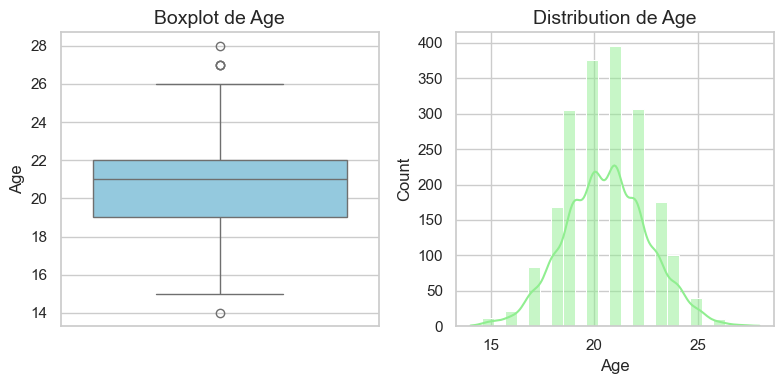

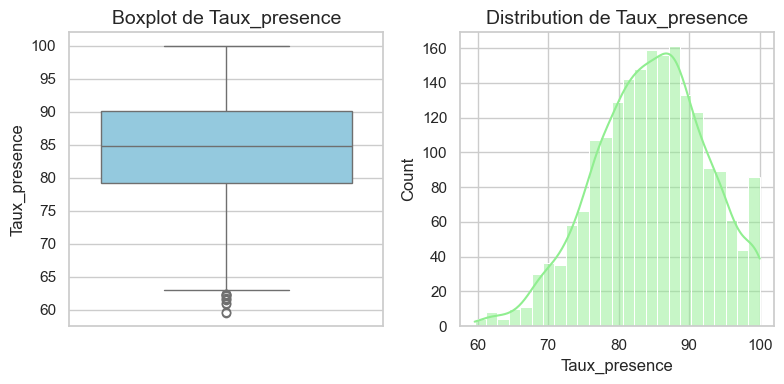

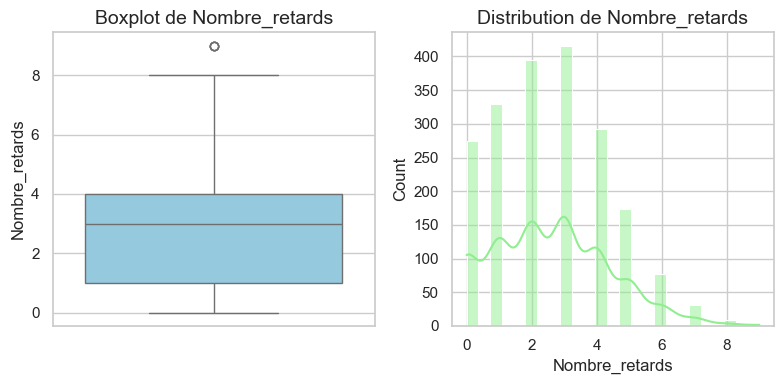

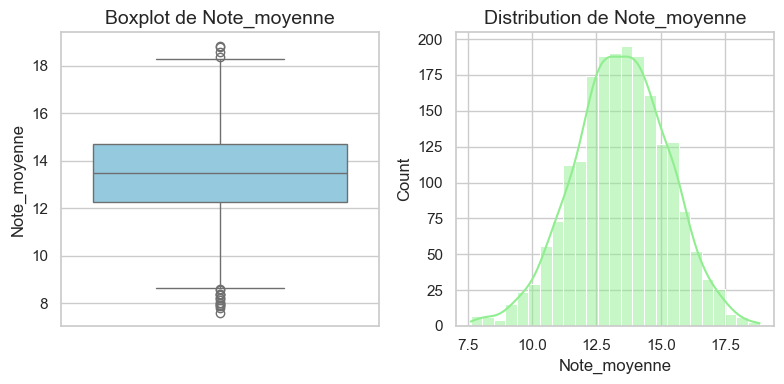

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_colonne(col):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 4))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f'Boxplot de {col}', fontsize=14)
    plt.xticks([])
    
    # Histogramme + KDE
    plt.subplot(1, 2, 2)
    sns.histplot(df[col], kde=True, color='lightgreen', bins=25)
    plt.title(f'Distribution de {col}', fontsize=14)
    
    plt.tight_layout()
    plt.show()

variables_numeriques = ['Age', 'Taux_presence', 'Nombre_retards', 'Note_moyenne']

for col in variables_numeriques:
    plot_colonne(col)


^^^

Les valeurs aberrantes présentes dans le jeu de données sont peu nombreuses et semblent crédibles. Elles ne justifient pas nécessairement une suppression.

Âge : 5 valeurs sont considérées comme aberrantes, notamment un minimum à 14 ans et un maximum à 28 ans. Bien que rares, ces âges pourraient refléter des cas réels.

Taux de présence : 12 valeurs sont anormalement basses, toutes situées autour de 59 à 62 %, bien en dessous de la moyenne générale. (peuvent influencer la prédiction d’abandon)

Nombre de retards : 4 valeurs atteignent le maximum de 9 retards. Ces valeurs ne nécessitent pas forcément de traitement.

Note moyenne : 19 valeurs extrêmes ont été détectées, aussi bien très faibles (< 8) que très élevées (> 18). Ces cas peuvent refléter des étudiants en grande difficulté ou très performants.

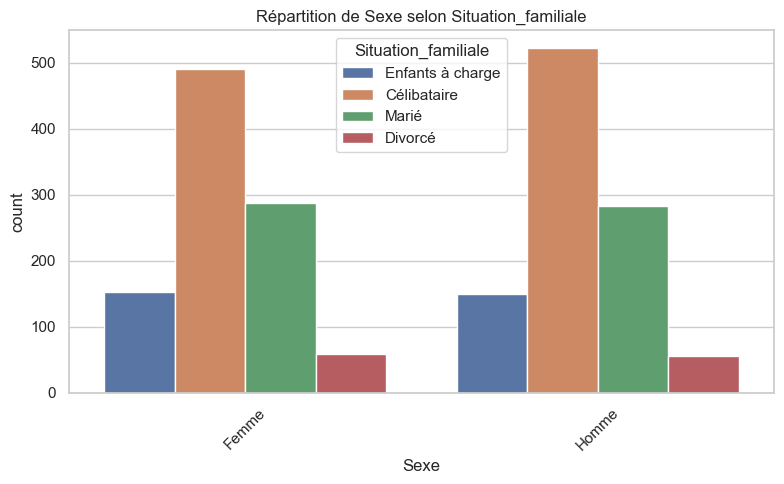

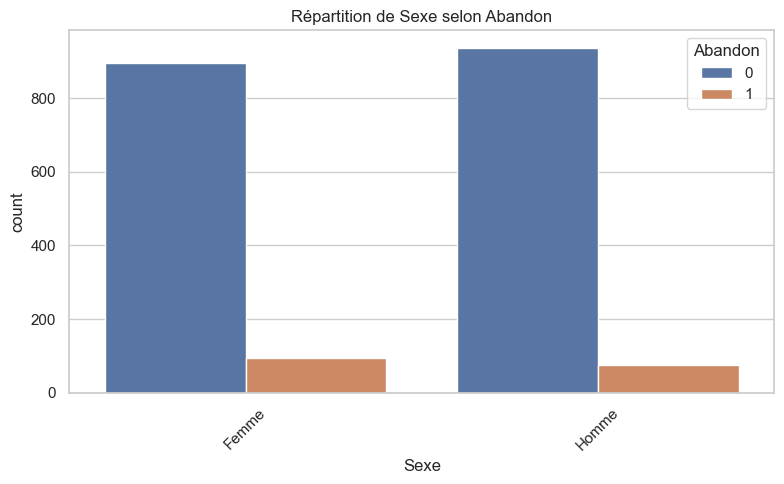

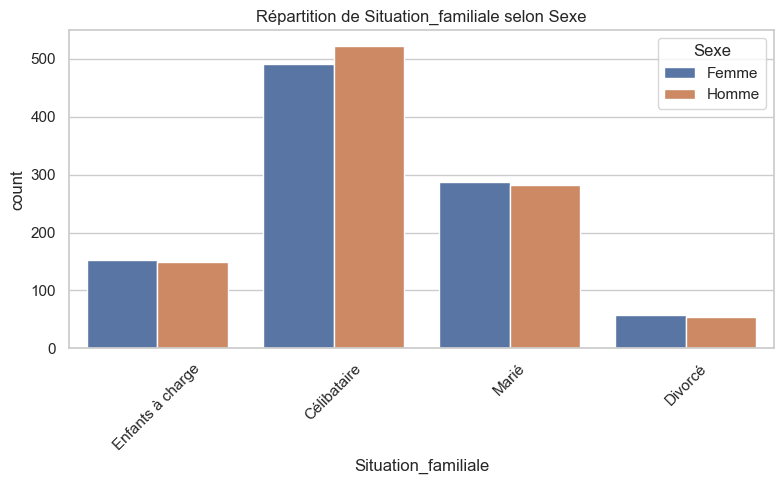

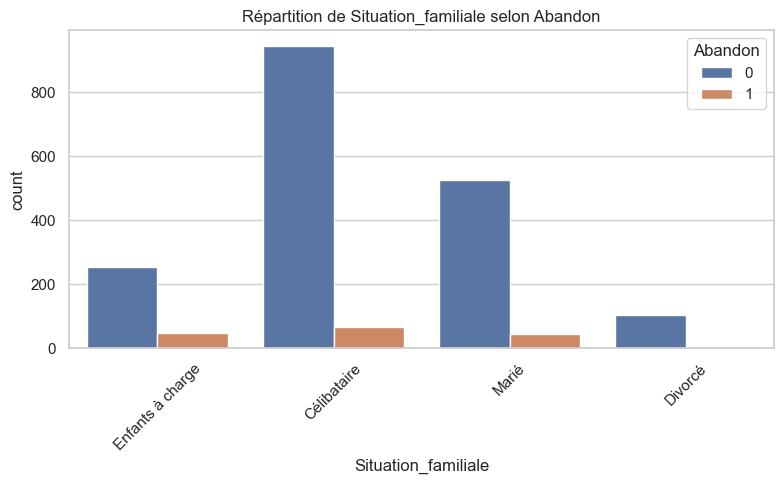

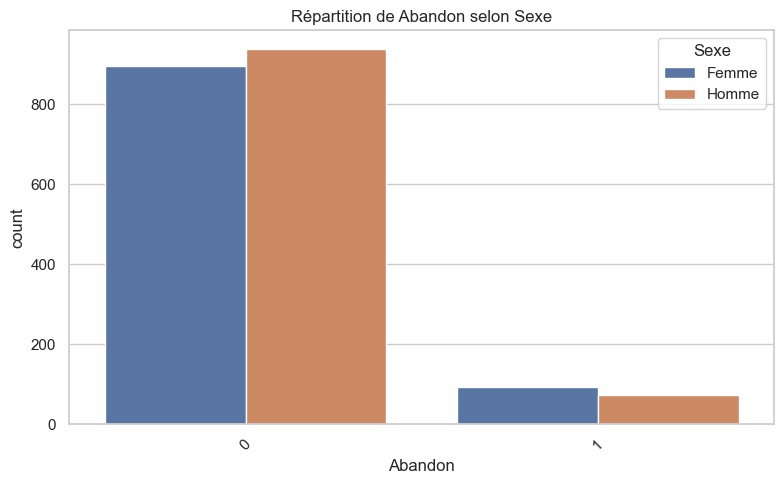

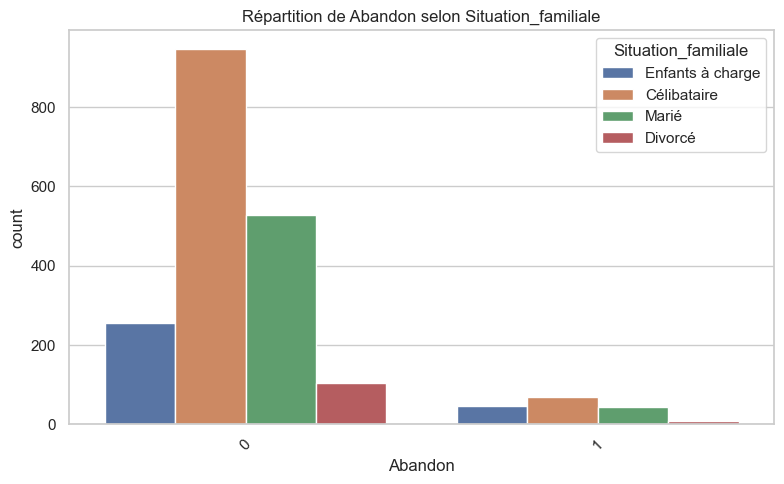

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


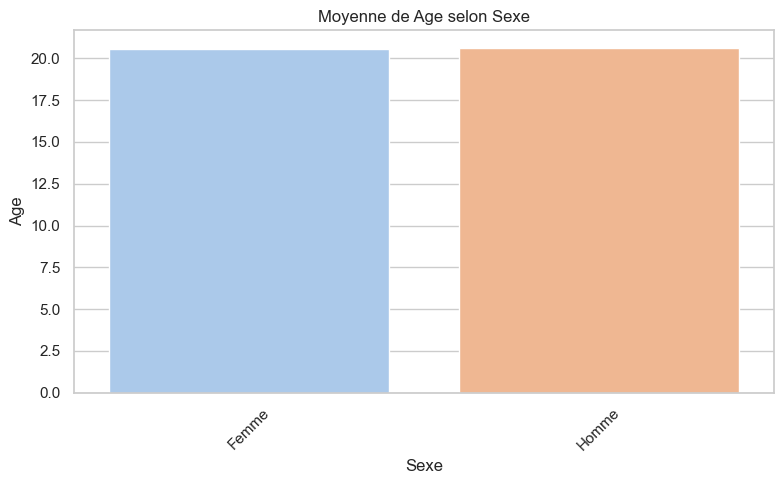

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


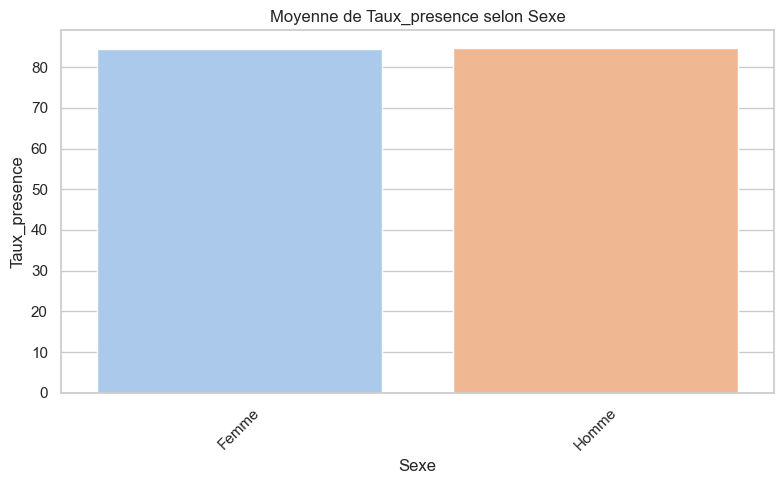

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


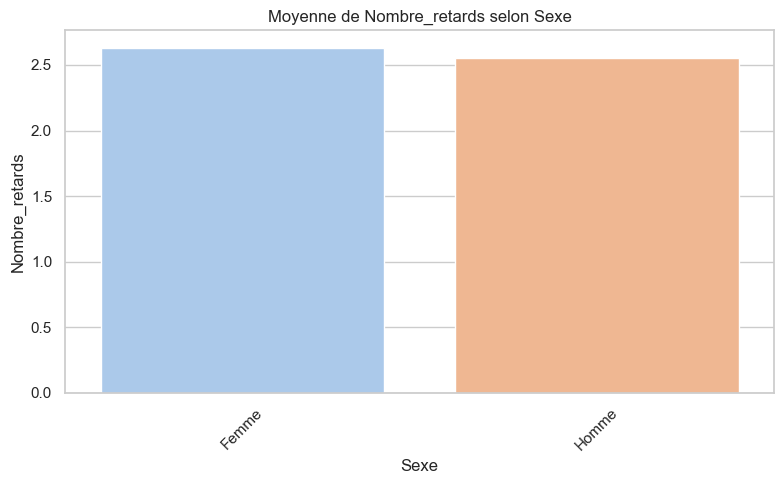

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


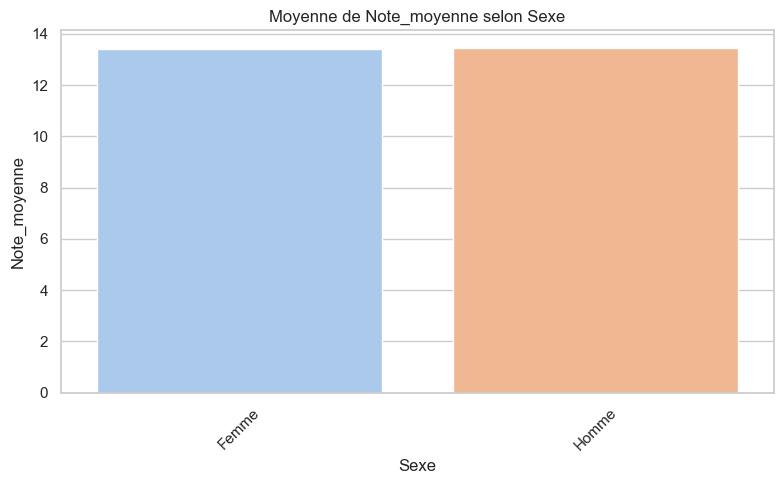

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


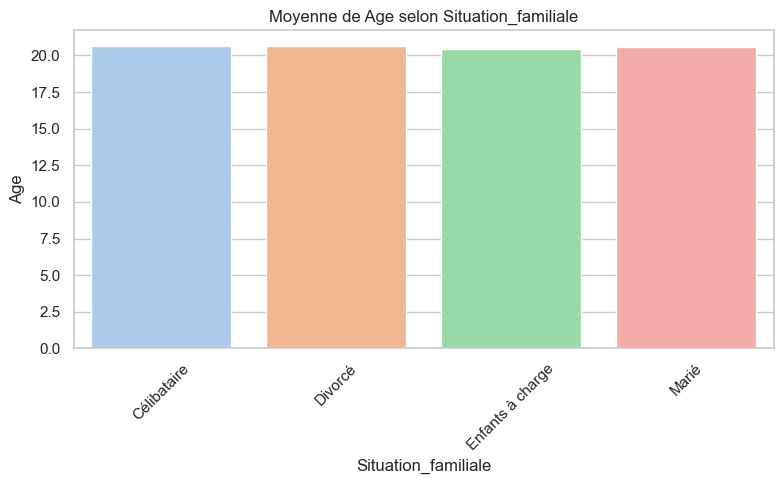

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


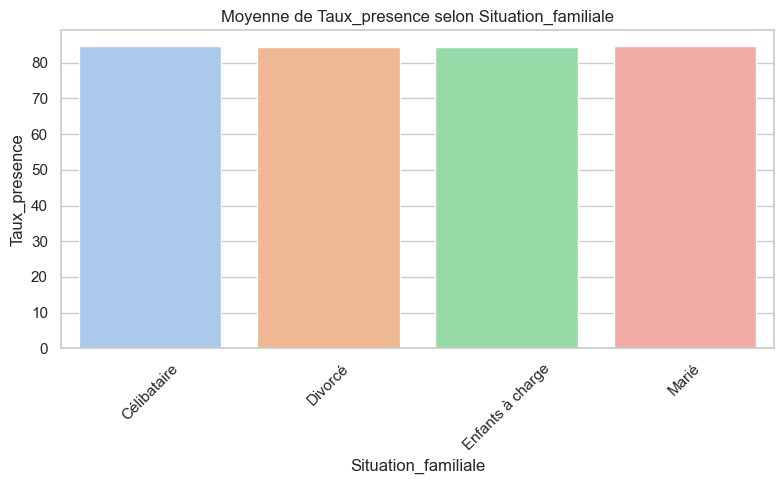

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


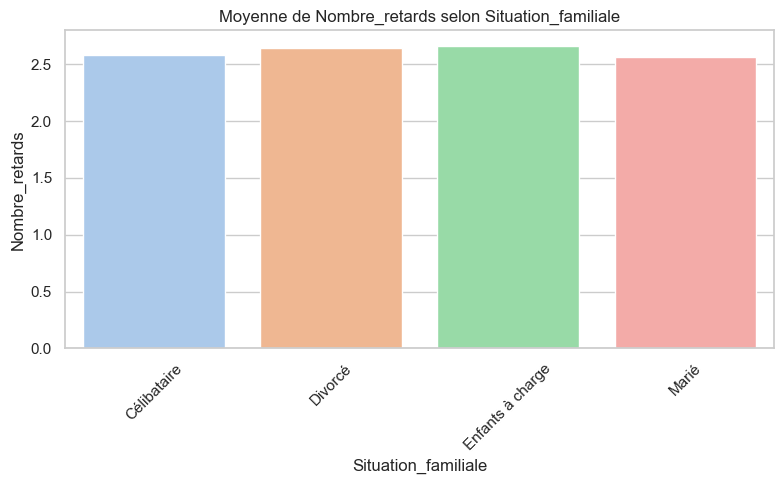

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


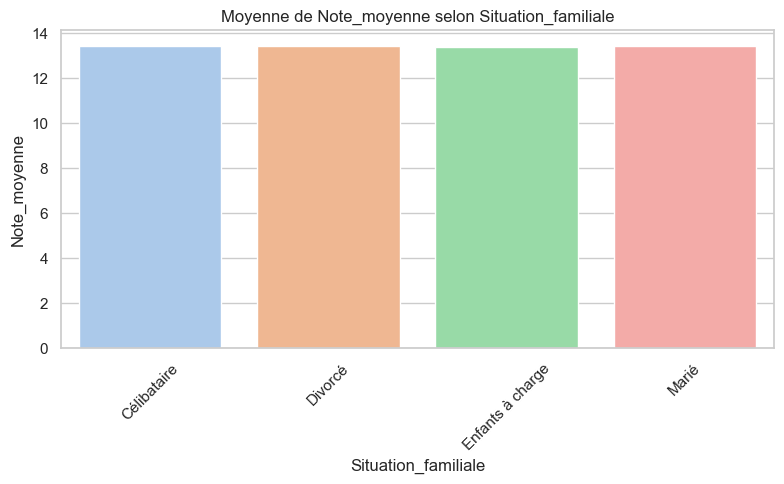

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


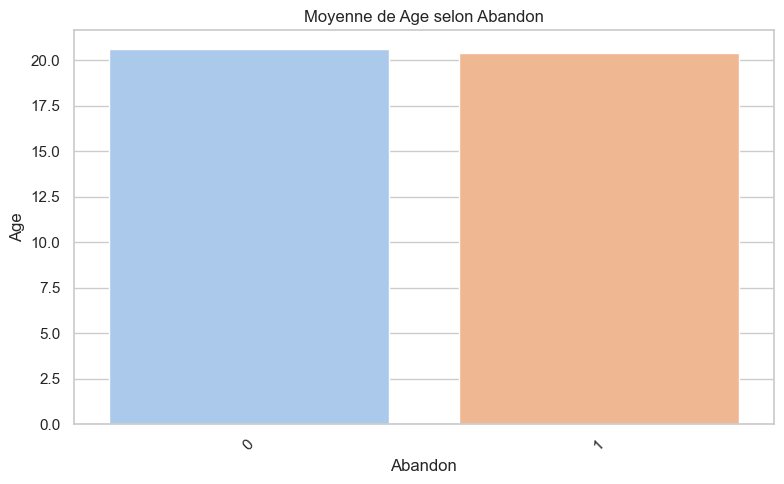

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


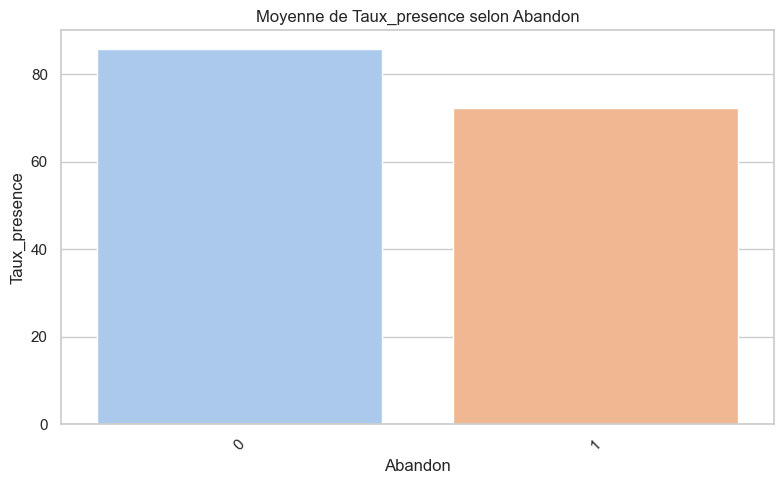

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


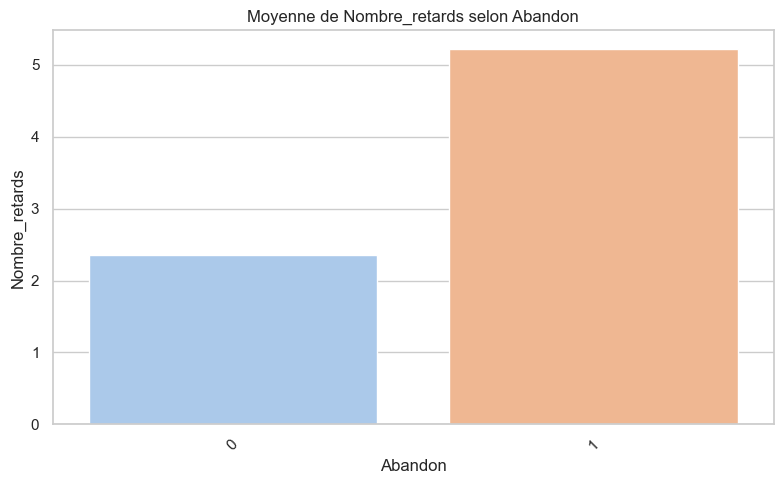

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\2744042057.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=means, x=cat, y=num, palette="pastel")


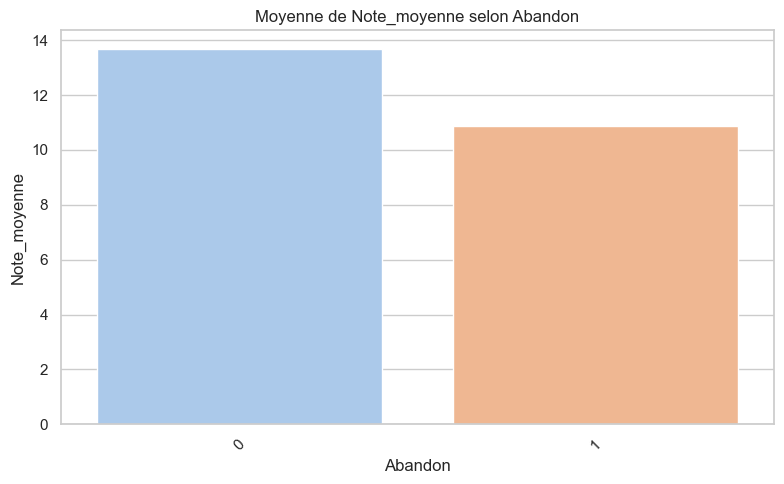

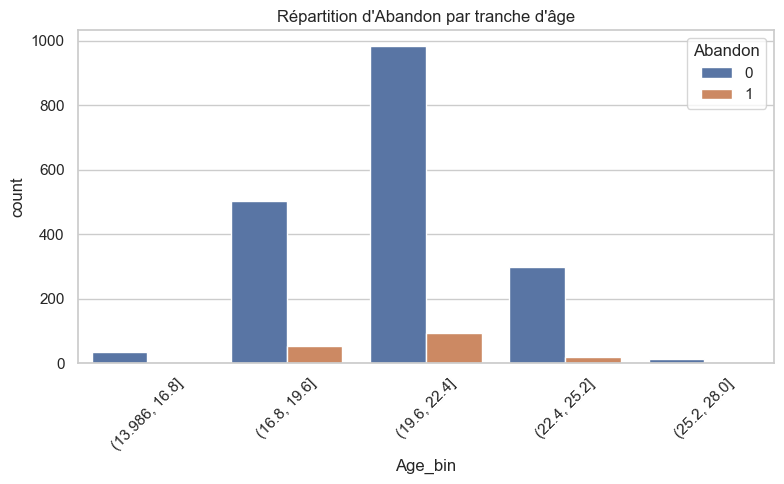

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

cat_cols = ['Sexe', 'Situation_familiale', 'Abandon']
num_cols = ['Age', 'Taux_presence', 'Nombre_retards', 'Note_moyenne']

# 1. Barplots pour les relations catégorie vs catégorie (countplots)
for cat1 in cat_cols:
    for cat2 in cat_cols:
        if cat1 != cat2:
            plt.figure()
            sns.countplot(data=df, x=cat1, hue=cat2)
            plt.title(f"Répartition de {cat1} selon {cat2}")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# 2. Barplots des moyennes des variables numériques selon chaque variable catégorielle
for cat in cat_cols:
    for num in num_cols:
        plt.figure()
        # Calcul des moyennes groupées
        means = df.groupby(cat)[num].mean().reset_index()
        sns.barplot(data=means, x=cat, y=num, palette="pastel")
        plt.title(f"Moyenne de {num} selon {cat}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 3. Catégorisation d'une variable numérique et countplot
df['Age_bin'] = pd.cut(df['Age'], bins=5)

plt.figure()
sns.countplot(data=df, x='Age_bin', hue='Abandon')
plt.title("Répartition d'Abandon par tranche d'âge")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df.drop('Age_bin', axis=1, inplace=True)


^^^

Analyse globale des visualisations :

L’étude montre que la majorité des étudiants sont célibataires, avec une répartition relativement équilibrée entre les hommes et les femmes. Les cas d’abandon restent peu fréquents et ne semblent pas influencés par le sexe ou la situation familiale. Ces variables ne ressortent donc pas comme des éléments déterminants dans la décision d’abandonner ou dans les performances scolaires.

Les données indiquent également que les moyennes d’âge, de taux de présence, de retards et de notes sont assez similaires d’une situation familiale à l’autre. L’âge moyen ne semble pas non plus jouer un rôle significatif dans l’abandon.

En revanche, des différences marquées apparaissent lorsque l’on compare les étudiants ayant abandonné aux autres. Ceux qui ont quitté leurs études présentent un taux de présence sensiblement plus faible, accumulent davantage de retards et obtiennent des notes inférieures à la moyenne. Cela laisse penser que l’engagement scolaire (via l’assiduité et la ponctualité) ainsi que la réussite académique sont des facteurs fortement liés au risque d’abandon.

Enfin, l’abandon ne semble pas concerner une tranche d’âge en particulier, mais touche surtout les groupes d’âge les plus représentés dans la population étudiée ([19.6, 22.4] ans).

En résumé, l’abandon scolaire semble avant tout corrélé au niveau d’implication et aux résultats académiques des étudiants, bien plus qu’à leurs caractéristiques sociodémographiques comme le sexe ou la situation familiale.

C:\Users\hamou\AppData\Local\Temp\ipykernel_17312\695452205.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


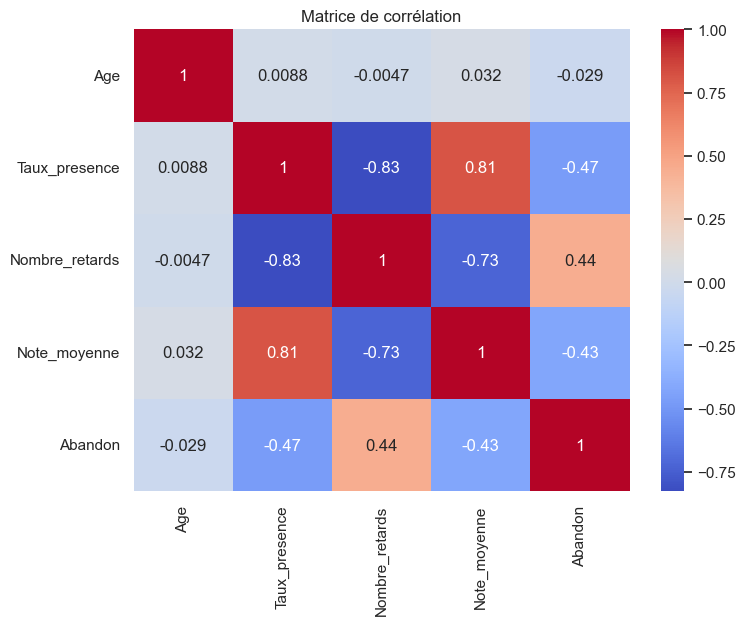

In [13]:
#Matrice de correlation
corr = df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matrice de corrélation")
plt.show()

^^^

Analyse de la matrice de corrélation

La matrice de corrélation révèle plusieurs relations significatives entre les variables :

1. Taux de présence :
   
   - Forte corrélation négative avec le nombre de retards (-0,83)
   - Forte corrélation positive avec la note moyenne (0,81)
   - Corrélation négative modérée avec l'abandon (-0,47)
2. Nombre de retards :
   
   - Corrélation négative forte avec la note moyenne (-0,73)
   - Corrélation positive modérée avec l'abandon (0,44)
3. Note moyenne :
   
   - Corrélation négative modérée avec l'abandon (-0,43)
4. Âge :
   
   - Absence de corrélation significative avec les autres variables (toutes les valeurs proches de 0)
Ces résultats confirment que le taux de présence, le nombre de retards et la note moyenne sont fortement interconnectés et liés au phénomène d'abandon. En revanche, l'âge ne semble pas jouer un rôle déterminant dans ces relations.

In [14]:
# Identifier les colonnes catégorielles automatiquement
colonnes_categoriques = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Colonnes catégorielles identifiées :")
print(colonnes_categoriques)

Colonnes catégorielles identifiées :
['Sexe', 'Situation_familiale']


In [15]:
le = LabelEncoder()
df["Sexe"] = le.fit_transform(df["Sexe"])
df["Situation_familiale"] = le.fit_transform(df["Situation_familiale"])

^^^

L'encodage des variables catégorielles à l'aide de LabelEncoder est une étape essentielle dans la préparation des données pour l'analyse en composantes principales (PCA) et l'entraînement des modèles de machine learning.

on a choisi d'utiliser le LabelEncoder parce que les variables "Sexe" et "Situation_familiale" ne comportent pas beaucoup de catégories différentes. Lorsque le nombre de catégories est limité, le LabelEncoder est particulièrement adapté car il attribue simplement un numéro à chaque catégorie, ce qui est suffisant et efficace dans ce cas. Cela permet de transformer rapidement ces variables en format numérique sans complexifier inutilement la représentation des données.

In [ ]:
X = df.drop("Abandon", axis=1)
y = df["Abandon"]

# Normalisation des données 
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)

^^^

Séparation des variables explicatives (X) et de la variable cible (y)
Pourquoi ?
La variable "Abandon" est la variable cible que le modèle doit prédire. On la sépare donc du reste du jeu de données pour ne pas biaiser l’apprentissage.

Intérêt ?
Cela permet de préparer correctement les données pour l'entraînement du modèle. Le modèle apprendra à prédire "Abandon" en se basant uniquement sur les autres variables.

^^^

Normalisation des données avec StandardScaler
La normalisation est une étape essentielle avant d'entraîner des modèles ou de réaliser une réduction de dimension comme la PCA. Elle permet de mettre toutes les variables sur une même échelle, ce qui est crucial lorsque les variables ont des unités différentes.

on a utilisé StandardScaler, qui standardise les données en leur donnant une moyenne nulle et un écart-type de 1. 
La transformation est appliquée uniquement sur X (les variables explicatives), et non sur y (la cible), car cette dernière est catégorielle (binaire) et n’a pas besoin d’être mise à l’échelle.



In [ ]:
# Création et application de la PCA
pca = PCA()
X_pca = pca.fit_transform(df_scaled)

# Création d'un DataFrame avec les composantes principales
pca_df = pd.DataFrame(
    data=X_pca,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]
)

# Affichage des premières lignes
print(pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6
0 -1.288626 -0.849863  0.477887  0.730979 -0.702885 -0.123473
1  1.343664  0.959362 -0.790122 -0.632682 -0.023953 -1.188568
2 -0.199850 -0.552595  0.765970  0.974109  0.747109 -0.597363
3 -0.615870  2.073083  0.342133  0.523838 -0.719511  0.091752
4  0.223559 -0.210807  1.030074 -1.343575  0.142666  0.432454


^^^

Réduction de dimension avec l’ACP (PCA)
L’Analyse en Composantes Principales (PCA) a été appliquée aux données normalisées (sans la variable cible Abandon) afin de transformer les variables explicatives en un nouvel ensemble de composantes principales indépendantes (PC1 à PC6).

Pourquoi utiliser la PCA ?
La PCA permet de :

réduire la dimensionnalité du jeu de données tout en conservant un maximum d'information,

identifier les structures sous-jacentes dans les données en supprimant les corrélations redondantes entre variables,

faciliter la visualisation des observations dans un espace à 2 ou 3 dimensions,

améliorer les performances des modèles en réduisant la complexité et en limitant le surapprentissage.


^^^

Chaque ligne du resultat représente une observation (un étudiant), projetée dans un nouvel espace sans corrélation entre dimensions. Par exemple :

L’individu 1 présente une forte contribution sur PC1, ce qui indique que ce premier axe résume une grande partie de ses caractéristiques (peut-être une combinaison d’un bon taux de présence, peu de retards et une bonne note).

L’individu 3 est élevé sur PC2 et PC4, ce qui peut révéler un autre profil type.

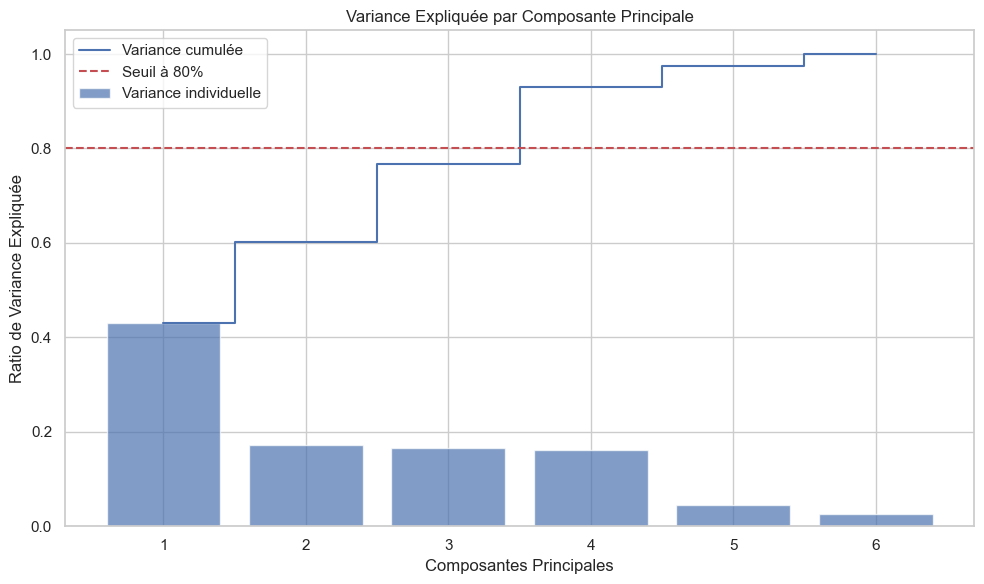

In [ ]:
# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Affichage de la variance expliquée
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Variance individuelle')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Variance cumulée')
plt.axhline(y=0.8, color='r', linestyle='--', label='Seuil à 80%')
plt.xlabel('Composantes Principales')
plt.ylabel('Ratio de Variance Expliquée')
plt.title('Variance Expliquée par Composante Principale')
plt.legend()
plt.tight_layout()
plt.show()

^^^

### Analyse du graphe de la variance expliquée (PCA)

Le graphique représente :
- En **barres bleues**, la *variance expliquée individuellement* par chaque composante principale (PC1 à PC6).
- En **courbe bleue**, la *variance cumulée* au fur et à mesure qu’on ajoute des composantes.
- Une **ligne rouge pointillée** à 80 %, qui représente un *seuil standard* utilisé pour juger de la suffisance de l'information retenue.



### Que nous apprend ce graphique ?

#### PC1 est très informative :
- La première composante explique **environ 43 %** de la variance totale.
- Cela signifie qu’à elle seule, elle résume presque la moitié de la structure du jeu de données initial.

#### PC2 et PC3 apportent un complément significatif :
- PC2 ajoute **environ 17 %**, et PC3 encore **17 %**.
- Ainsi, avec les **3 premières composantes**, on atteint **près de 77 %** de la variance totale expliquée.

#### Le seuil des 80 % est presque atteint avec PC4 :
- L’ajout de la **quatrième composante** permet de dépasser ce seuil, ce qui confirme que :

> *Les 4 premières composantes principales contiennent l’essentiel de l’information utile du jeu de données initial.*

- En réduisant à **4 dimensions au lieu de 6**, on **simplifie les calculs** et les **visualisations** sans perdre beaucoup d’information.


In [19]:
# Détermination du nombre de composantes pour atteindre 80% de variance expliquée
n_components = np.argmax(cumulative_variance >= 0.8) + 1
print(f"Nombre de composantes nécessaires pour expliquer 80% de la variance: {n_components}")

# Application de la PCA avec le nombre optimal de composantes
pca_optimal = PCA(n_components=n_components)
X_pca_optimal = pca_optimal.fit_transform(df_scaled)

Nombre de composantes nécessaires pour expliquer 80% de la variance: 4


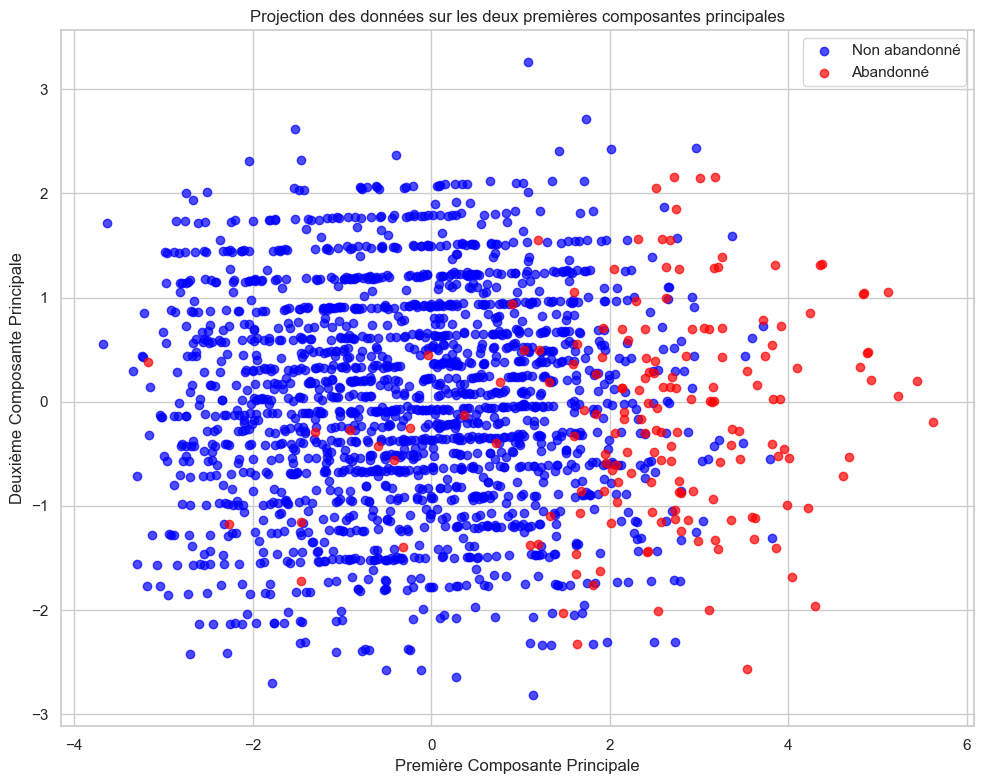

In [20]:
# Visualisation des deux premières composantes principales avec coloration selon la variable "abandon"
plt.figure(figsize=(10, 8))

# Création de masques pour chaque valeur d'abandon
abandon_true = df['Abandon'] == 1  
abandon_false = ~abandon_true

# Tracer les points avec des couleurs différentes
plt.scatter(X_pca[abandon_false, 0], X_pca[abandon_false, 1], color='blue', alpha=0.7, label='Non abandonné')
plt.scatter(X_pca[abandon_true, 0], X_pca[abandon_true, 1], color='red', alpha=0.7, label='Abandonné')

plt.xlabel('Première Composante Principale')
plt.ylabel('Deuxième Composante Principale')
plt.title('Projection des données sur les deux premières composantes principales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

^^^

ce code crée un nuage de points. Il projette les données transformées par PCA ( X_pca ) sur un graphique en 2D, où l'axe des abscisses représente la première composante principale et l'axe des ordonnées la deuxième. Les points sont colorés en fonction de la variable "Abandon" : les points bleus correspondent aux individus qui n'ont pas abandonné, et les points rouges à ceux qui ont abandonné. Cette visualisation permet d'observer la répartition spatiale des deux groupes dans l'espace réduit des deux premières composantes principales.

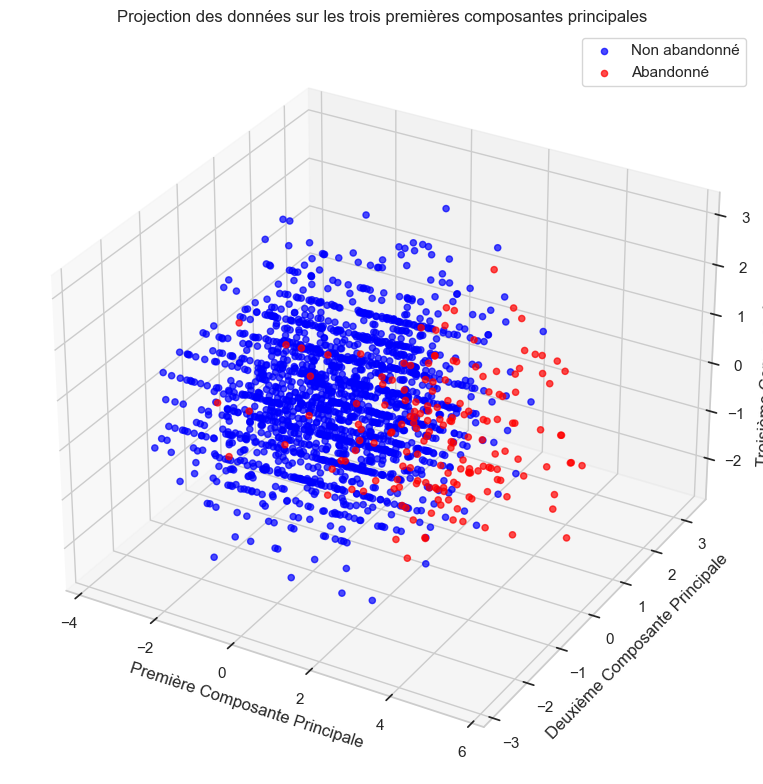

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Supposons que tu as un masque pour la variable 'Abandon' comme avant
ax.scatter(X_pca[abandon_false, 0], X_pca[abandon_false, 1], X_pca[abandon_false, 2], 
           color='blue', alpha=0.7, label='Non abandonné')
ax.scatter(X_pca[abandon_true, 0], X_pca[abandon_true, 1], X_pca[abandon_true, 2], 
           color='red', alpha=0.7, label='Abandonné')

ax.set_xlabel('Première Composante Principale')
ax.set_ylabel('Deuxième Composante Principale')
ax.set_zlabel('Troisième Composante Principale')
ax.set_title('Projection des données sur les trois premières composantes principales')
ax.legend()
plt.tight_layout()
plt.show()

^^^

ce code utilise la bibliothèque matplotlib.pyplot et l'extension mpl_toolkits.mplot3d pour créer un nuage de points en trois dimensions. Il projette les données transformées par PCA ( X_pca ) sur un graphique 3D, où les axes représentent respectivement la première, la deuxième et la troisième composante principale. Les points sont colorés en fonction de la variable "Abandon" : les points bleus correspondent aux individus qui n'ont pas abandonné, et les points rouges à ceux qui ont abandonné. Cette visualisation permet d'observer la répartition spatiale des deux groupes dans l'espace réduit des trois premières composantes principales.

### Que nous apprennent ces graphiques ? Séparabilité des classes :
- Le graphique montre la distribution des points "Non abandonné" (bleu) et "Abandonné" (rouge) dans le plan défini par les deux premières composantes principales.
- Une séparation claire entre les points bleus et rouges dans ce graphique indiquerait que les deux ou trois premières composantes principales sont efficaces pour distinguer les deux classes. Observation de la distribution :
- On observe que les points bleus et rouges sont largement entremêlés dans le plan des deux et des trois premières composantes principales.
- Bien qu'il puisse y avoir une légère tendance des points rouges à se situer dans certaines régions (par exemple, vers la droite du graphique), il n'y a pas de frontière nette permettant de séparer facilement les deux groupes. Qualité des données et chevauchement :
- Ce chevauchement important entre les deux classes dans l'espace des premières composantes principales suggère que les caractéristiques disponibles, même après réduction de dimensionnalité, ne permettent pas une distinction claire entre les individus qui abandonnent et ceux qui n'abandonnent pas.
- Ce manque de séparabilité peut être lié à la qualité intrinsèque des données ou à l'absence de variables fortement discriminantes dans le jeu de données initial. Implication pour la modélisation :
- Le mélange des points suggère que les deux premières composantes principales seules ne sont pas suffisantes pour construire un modèle de classification performant basé uniquement sur ces dimensions réduites.
- La qualité des données, telle qu'illustrée par ce chevauchement, pourrait affecter la capacité des modèles de machine learning à apprendre une frontière de décision efficace entre les deux classes, potentiellement limitant leurs performances prédictives.
- D'autres composantes principales pourraient contenir des informations discriminantes supplémentaires, ou d'autres techniques de réduction de dimensionnalité ou de sélection de caractéristiques pourraient être plus appropriées pour ce problème de classification.

In [ ]:
features_columns = X.columns.tolist()  # Liste des noms des colonnes en entrée PCA

^^^

Cette ligne de code crée une liste nommée features_columns contenant les noms de toutes les colonnes présentes dans le DataFrame X . Le DataFrame X contient les variables explicatives utilisées pour l'analyse.

L'utilité de cette liste est de conserver une trace des noms des caractéristiques originales avant qu'elles ne soient transformées par des étapes comme la normalisation ( StandardScaler ) et la réduction de dimensionnalité par PCA.

Conserver les noms des colonnes originales est important pour plusieurs raisons :

- Interprétation de la PCA : Cela permet de comprendre quelles caractéristiques originales contribuent le plus à chaque composante principale. En analysant les poids (loadings) des composantes principales, associés aux noms des caractéristiques, il est possible d'interpréter la signification de chaque composante en termes des variables initiales.
- Interprétation des modèles : Si les composantes principales sont utilisées comme entrées pour un modèle de machine learning, il peut être utile de relier les résultats du modèle (par exemple, l'importance des caractéristiques) aux variables originales.
- Traçabilité : Maintenir une liste des caractéristiques utilisées assure la traçabilité du processus d'analyse et de modélisation.

In [30]:
composantes_df = pd.DataFrame(
    pca.components_,
    columns=features_columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
print(composantes_df.iloc[:4].T.sort_values(by='PC1', ascending=False))


                          PC1       PC2       PC3       PC4
Nombre_retards       0.572031  0.022195  0.009298  0.011352
Situation_familiale  0.003334 -0.501311  0.809305 -0.305902
Age                 -0.017032  0.580818  0.576939  0.573267
Sexe                -0.020629  0.640726  0.109709 -0.759478
Note_moyenne        -0.567460 -0.003064 -0.000268  0.028153
Taux_presence       -0.591645 -0.017488 -0.006625 -0.007773


^^^

### Analyse du tableau des composantes principales
Le tableau affiché est un DataFrame pandas ( composantes_df ) qui présente les coefficients (ou "loadings") de chaque variable originale sur les quatre premières composantes principales (PC1, PC2, PC3 et PC4). Chaque ligne correspond à une variable originale, et chaque colonne correspond à une composante principale. La valeur dans chaque cellule indique l'importance et la direction de la relation entre la variable originale et la composante principale. Le tableau est trié par ordre décroissant des coefficients sur PC1.

### Que nous apprend ce tableau ?
Le tableau des coefficients permet d'interpréter la signification de chaque composante principale en identifiant les variables originales qui y contribuent le plus.
 Interprétation de PC1 :
- PC1 est fortement corrélée positivement avec Nombre_retards (0.572) et négativement avec Taux_presence (-0.591) et Note_moyenne (-0.567).
- Cela confirme que PC1 capture principalement un axe lié à la performance et au comportement académique. Des valeurs élevées sur PC1 sont associées à des difficultés (retards, faible présence, mauvaises notes), tandis que des valeurs faibles sont associées à la réussite académique. Interprétation de PC2 :
- PC2 est fortement corrélée positivement avec Sexe (0.640) et Age (0.580), et négativement avec Situation_familiale (-0.501).
- PC2 représente un axe lié aux caractéristiques démographiques et personnelles des individus. Interprétation de PC3 :
- PC3 est fortement corrélée positivement avec Situation_familiale (0.809) et Age (0.576).
- PC3 semble également capturer des aspects liés à la situation familiale et à l'âge, apportant une dimension supplémentaire par rapport à PC2 pour ces variables. Interprétation de PC4 :
- PC4 est fortement corrélée négativement avec Sexe (-0.759) et positivement avec Age (0.573).
- PC4 est principalement influencée par le sexe et l'âge, avec une contribution particulièrement forte du sexe.
En résumé, l'analyse de ce tableau permet de caractériser les quatre premières composantes principales :

- PC1 : Principalement liée à la performance et au comportement académique.
- PC2, PC3, PC4 : Liées aux caractéristiques démographiques et personnelles (Sexe, Age, Situation familiale), chacune capturant différents aspects de ces variables.

^^^

### Concepts importants distingués par la PCA
L'analyse des coefficients (loadings) permet d'identifier les variables originales qui contribuent le plus à chaque composante principale, et ainsi d'interpréter les "concepts" ou les axes de variation sous-jacents dans les données :

1. Premier concept (PC1) : Performance et comportement académique. PC1 est fortement corrélée avec Nombre_retards , Taux_presence et Note_moyenne . Cet axe représente une dimension liée aux résultats scolaires et à l'assiduité.
2. Deuxième concept (PC2, PC3, PC4) : Caractéristiques démographiques et personnelles. PC2, PC3 et PC4 sont principalement influencées par Sexe , Age et Situation_familiale . Ces composantes capturent différentes facettes de ces variables personnelles et démographiques. Bien qu'elles soient liées aux mêmes variables originales, elles représentent des combinaisons distinctes de celles-ci. On peut donc considérer qu'il y a un deuxième ensemble de facteurs importants liés aux caractéristiques individuelles.
En se basant sur les quatre premières composantes qui expliquent la majorité de la variance, on distingue principalement deux types de facteurs importants dans les données : ceux liés à la performance académique et ceux liés aux caractéristiques démographiques/personnelles.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.2, random_state=42, stratify=y)

^^^

Cette ligne de code utilise la fonction train_test_split de la bibliothèque scikit-learn pour diviser le jeu de données en deux sous-ensembles : un ensemble d'entraînement ( X_train , y_train ) et un ensemble de test ( X_test , y_test ).

La division des données est une étape fondamentale dans le processus d'entraînement et d'évaluation des modèles de machine learning. L'ensemble d'entraînement est utilisé pour apprendre les paramètres du modèle, tandis que l'ensemble de test, qui n'a jamais été vu par le modèle pendant l'entraînement, sert à évaluer ses performances sur de nouvelles données. Cela permet d'obtenir une estimation fiable de la capacité du modèle à généraliser à des données inconnues et d'éviter le surapprentissage.

Les paramètres utilisés ont les significations suivantes :

- df_scaled : Les caractéristiques (variables explicatives) normalisées, qui seront divisées.
- y : La variable cible ("Abandon"), qui sera également divisée de manière correspondante.
- test_size=0.2 : Spécifie que 20 % des données seront allouées à l'ensemble de test, et les 80 % restants à l'ensemble d'entraînement.
- random_state=42 : Assure que la division des données est reproductible. En utilisant la même valeur pour random_state , on obtient toujours la même division du jeu de données à chaque exécution du code.
- stratify=y : Garantit que la proportion des classes de la variable cible ( y ) est la même dans les ensembles d'entraînement et de test que dans le jeu de données original. Ceci est particulièrement important pour les problèmes de classification avec des classes déséquilibrées, afin que chaque ensemble soit représentatif de la distribution globale des classes.


===== KNN =====
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       366
           1       0.74      0.50      0.60        34

    accuracy                           0.94       400
   macro avg       0.85      0.74      0.78       400
weighted avg       0.94      0.94      0.94       400

Matrice de confusion :
 [[360   6]
 [ 17  17]]


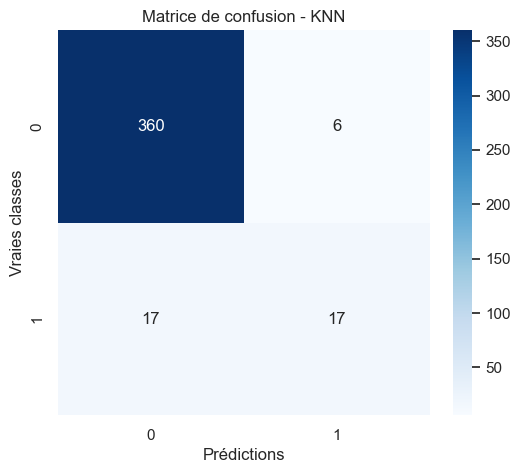


===== Decision Tree =====
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       366
           1       0.55      0.68      0.61        34

    accuracy                           0.93       400
   macro avg       0.76      0.81      0.78       400
weighted avg       0.93      0.93      0.93       400

Matrice de confusion :
 [[347  19]
 [ 11  23]]


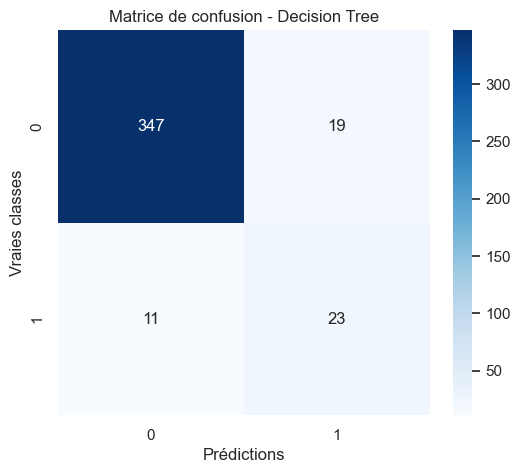


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       366
           1       0.68      0.56      0.61        34

    accuracy                           0.94       400
   macro avg       0.82      0.77      0.79       400
weighted avg       0.94      0.94      0.94       400

Matrice de confusion :
 [[357   9]
 [ 15  19]]


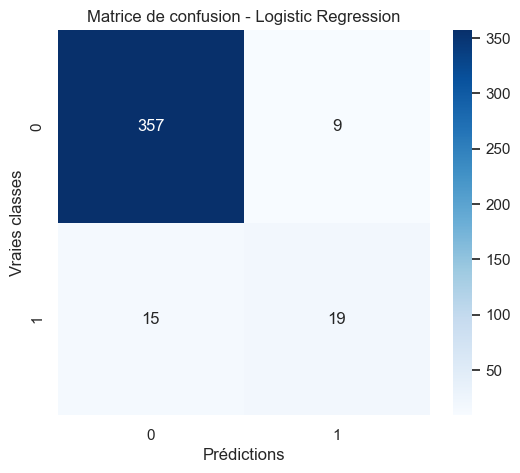


Meilleur K pour KNN : {'n_neighbors': 13}
Meilleure profondeur pour Decision Tree : {'max_depth': 1}

=== Best KNN ===
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       366
           1       0.72      0.53      0.61        34

    accuracy                           0.94       400
   macro avg       0.84      0.76      0.79       400
weighted avg       0.94      0.94      0.94       400

Matrice de confusion :
 [[359   7]
 [ 16  18]]


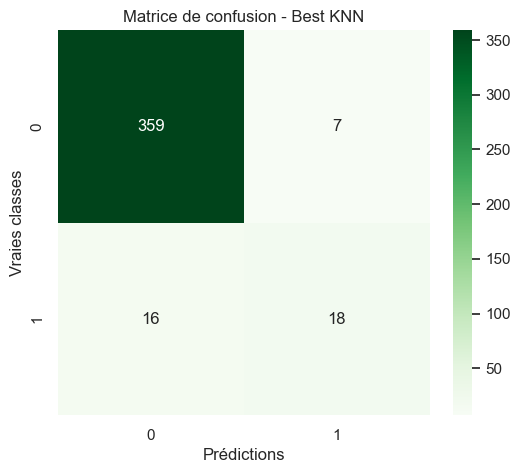


=== Best Decision Tree ===
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       366
           1       0.59      0.85      0.70        34

    accuracy                           0.94       400
   macro avg       0.79      0.90      0.83       400
weighted avg       0.95      0.94      0.94       400

Matrice de confusion :
 [[346  20]
 [  5  29]]


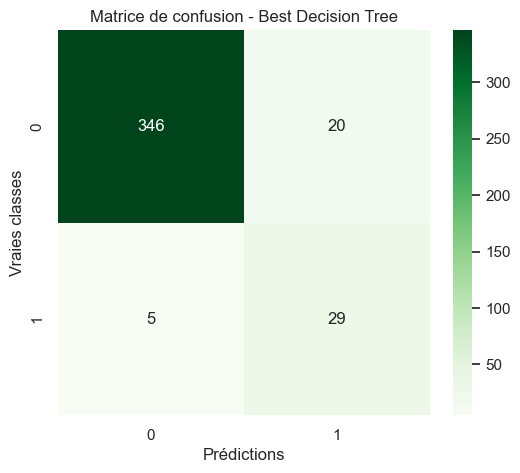


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       366
           1       0.68      0.56      0.61        34

    accuracy                           0.94       400
   macro avg       0.82      0.77      0.79       400
weighted avg       0.94      0.94      0.94       400

Matrice de confusion :
 [[357   9]
 [ 15  19]]


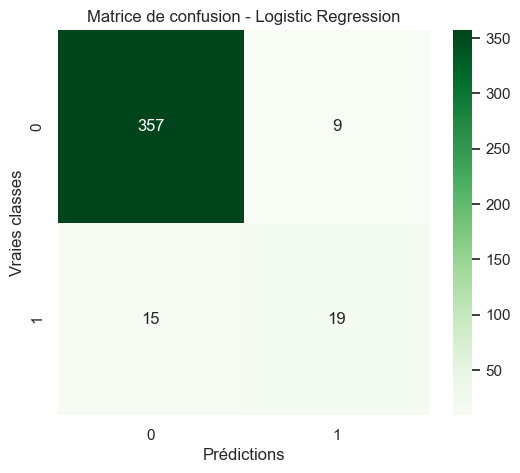

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Définition des modèles
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Entraînement et évaluation des modèles
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    print("Matrice de confusion :\n", cm)
    
    # Visualisation matrice de confusion
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {name}')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies classes')
    plt.show()

# Recherche des meilleurs hyperparamètres avec GridSearchCV

# Pour KNN
param_grid_knn = {'n_neighbors': range(1, 15)}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_knn.fit(X_train, y_train)
print("\nMeilleur K pour KNN :", grid_knn.best_params_)

# Pour Decision Tree
param_grid_tree = {'max_depth': range(1, 10)}
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_tree, cv=5)
grid_tree.fit(X_train, y_train)
print("Meilleure profondeur pour Decision Tree :", grid_tree.best_params_)

# Évaluation finale des meilleurs modèles avec visualisation

best_models = {
    "Best KNN": grid_knn.best_estimator_,
    "Best Decision Tree": grid_tree.best_estimator_,
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

for name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    print("Matrice de confusion :\n", cm)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Matrice de confusion - {name}')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies classes')
    plt.show()


^^^

Ce code exécute un processus d'entraînement et d'évaluation pour plusieurs modèles de classification : KNeighborsClassifier , DecisionTreeClassifier et LogisticRegression .

Le script procède en plusieurs étapes :

1. Définition des modèles : Des instances des modèles de classification sont initialisées.
2. Entraînement et évaluation initiale : Chaque modèle est entraîné sur l'ensemble de données d'entraînement ( X_train , y_train ). Des prédictions sont ensuite effectuées sur l'ensemble de test ( X_test ). Pour chaque modèle, un rapport de classification et une matrice de confusion sont calculés et affichés. Une visualisation graphique de la matrice de confusion est également générée.
3. Optimisation des hyperparamètres : La fonction GridSearchCV est utilisée pour rechercher les meilleurs hyperparamètres ( n_neighbors pour KNN, max_depth pour l'arbre de décision) en utilisant la validation croisée sur l'ensemble d'entraînement. Les meilleurs hyperparamètres trouvés sont affichés.
4. Évaluation finale des meilleurs modèles : Les modèles avec les meilleurs hyperparamètres trouvés (ainsi que la régression logistique non optimisée) sont évalués une dernière fois sur l'ensemble de test. Le rapport de classification et la matrice de confusion sont à nouveau affichés et visualisés pour ces modèles optimisés.
Les sorties principales de ce code sont les rapports de classification et les matrices de confusion pour chaque modèle, avant et après optimisation.

- Rapport de classification : Fournit des métriques de performance par classe :
  
  - Précision : Proportion d'instances correctement prédites pour une classe parmi toutes les instances prédites pour cette classe.
  - Rappel : Proportion d'instances correctement prédites pour une classe parmi toutes les instances réelles de cette classe.
  - Score F1 : Moyenne harmonique de la précision et du rappel.
  - Support : Nombre réel d'instances de la classe dans l'ensemble de test.
    Des moyennes globales (accuracy, macro avg, weighted avg) sont également incluses.
- Matrice de confusion : Un tableau résumant les résultats de la classification.
  
  - Les lignes représentent les vraies classes.
  - Les colonnes représentent les classes prédites.
  - Les cellules contiennent le nombre de Vrais Positifs (TP), Vrais Négatifs (TN), Faux Positifs (FP) et Faux Négatifs (FN).

In [26]:
# Entraînement du KMeans avec un nombre de clusters = 2 (car 2 classes dans Abandon)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca_optimal)

# Evaluation du clustering
ari = adjusted_rand_score(y, clusters)
sil_score = silhouette_score(X_pca_optimal, clusters)

print(f"Adjusted Rand Index (ARI) : {ari:.3f}")
print(f"Silhouette Score : {sil_score:.3f}")


C:\Users\hamou\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI) : 0.032
Silhouette Score : 0.255


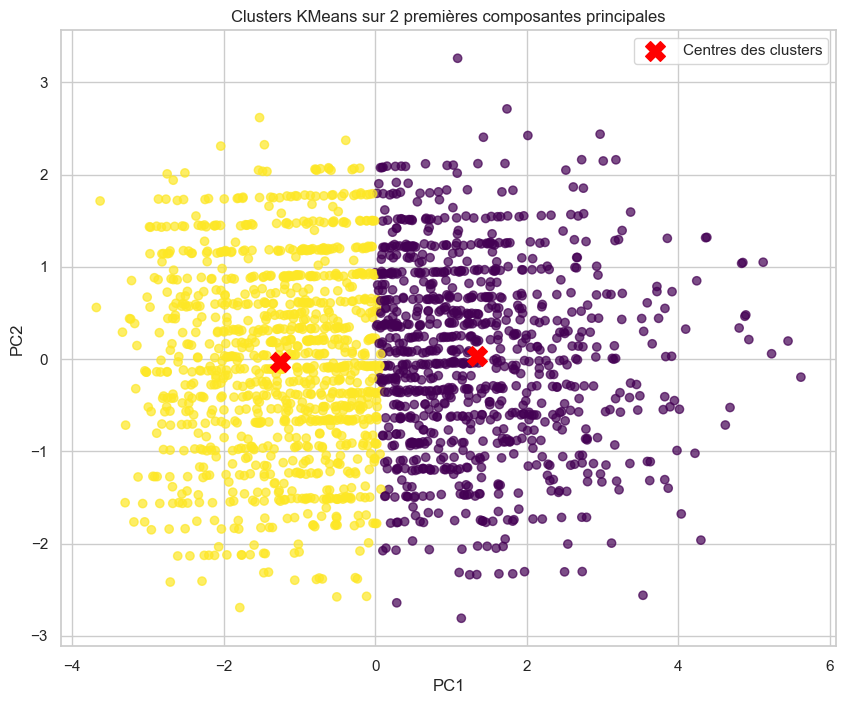

In [27]:
plt.figure(figsize=(10, 8))

plt.scatter(X_pca_optimal[:, 0], X_pca_optimal[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', marker='X', label='Centres des clusters')

plt.title("Clusters KMeans sur 2 premières composantes principales")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.show()


### Interprétation des métriques de classification
Avant d'analyser les modèles spécifiques, il est important de comprendre les métriques utilisées :

- Précision (Precision) : Pour la classe "Abandonné" (classe 1), la précision indique la proportion d'individus prédits comme ayant abandonné qui ont réellement abandonné. Une précision élevée pour la classe 1 signifie que lorsqu'un modèle prédit qu'un individu va abandonner, il a de fortes chances d'avoir raison (peu de faux positifs). Pour la classe "Non abandonné" (classe 0), c'est la proportion d'individus prédits comme n'ayant pas abandonné qui n'ont réellement pas abandonné.
- Rappel (Recall) : Pour la classe "Abandonné" (classe 1), le rappel indique la proportion d'individus qui ont réellement abandonné et qui ont été correctement identifiés par le modèle. Un rappel élevé pour la classe 1 signifie que le modèle parvient à détecter une grande partie des cas réels d'abandon (peu de faux négatifs). Pour la classe "Non abandonné" (classe 0), c'est la proportion d'individus qui n'ont réellement pas abandonné et qui ont été correctement identifiés.
- Score F1 (F1-Score) : C'est une moyenne harmonique de la précision et du rappel. Il est utile lorsque l'on recherche un équilibre entre ces deux métriques, particulièrement important pour la classe minoritaire ("Abandonné").
- Support : Le nombre réel d'instances de chaque classe dans l'ensemble de test (366 pour "Non abandonné", 34 pour "Abandonné"). Cela confirme un déséquilibre de classes important.
- Matrice de confusion :
  - La cellule en haut à gauche (360, 347, 357, 359, 346, 357) représente les Vrais Négatifs (TN) : individus "Non abandonné" correctement prédits comme "Non abandonné".
  - La cellule en haut à droite (6, 19, 9, 7, 20, 9) représente les Faux Positifs (FP) : individus "Non abandonné" incorrectement prédits comme "Abandonné".
  - La cellule en bas à gauche (17, 11, 15, 16, 5, 15) représente les Faux Négatifs (FN) : individus "Abandonné" incorrectement prédits comme "Non abandonné".
  - La cellule en bas à droite (17, 23, 19, 18, 29, 19) représente les Vrais Positifs (TP) : individus "Abandonné" correctement prédits comme "Abandonné".
Dans ce contexte de prédiction de l'abandon, une bonne précision pour la classe "Abandonné" signifie que les alertes générées par le modèle sont fiables (peu d'étudiants signalés à tort comme à risque). Un bon rappel pour la classe "Abandonné" signifie que le modèle identifie la majorité des étudiants qui vont réellement abandonner (peu d'étudiants à risque manqués). Selon l'objectif (minimiser les fausses alertes vs. minimiser les cas manqués), on peut privilégier l'une ou l'autre métrique, ou chercher un équilibre avec le score F1.

### Analyse des performances des modèles Modèles initiaux :
- KNN : Bonne précision (0.95) et rappel (0.98) pour la classe 0. Pour la classe 1, précision modérée (0.74) mais rappel faible (0.50). Le score F1 pour la classe 1 est de 0.60. La matrice de confusion montre 17 TP et 17 FN, ce qui signifie qu'il manque la moitié des cas d'abandon.
- Decision Tree : Très bonne précision (0.97) pour la classe 0, mais rappel légèrement plus faible (0.95). Pour la classe 1, précision plus faible (0.55) mais meilleur rappel (0.68) que KNN. Le score F1 pour la classe 1 est de 0.61. La matrice de confusion montre 23 TP et 11 FN, détectant plus de cas d'abandon que KNN initial.
- Logistic Regression : Bonne précision (0.96) et rappel (0.98) pour la classe 0. Pour la classe 1, précision modérée (0.68) et rappel modéré (0.56). Le score F1 pour la classe 1 est de 0.61. La matrice de confusion montre 19 TP et 15 FN.
Initialement, l'Arbre de Décision a le meilleur rappel pour la classe "Abandonné", tandis que KNN a la meilleure précision pour cette classe. La Régression Logistique se situe entre les deux. Tous les modèles ont d'excellentes métriques pour la classe majoritaire ("Non abandonné") en raison du déséquilibre.
 Optimisation des hyperparamètres :
- GridSearchCV a trouvé n_neighbors=13 comme meilleur hyperparamètre pour KNN et max_depth=1 pour l'Arbre de Décision. Une profondeur maximale de 1 pour l'arbre de décision indique un modèle très simple (un seul split). Meilleurs modèles (après optimisation) :
- Best KNN : Performances très similaires au KNN initial. Légère baisse du rappel pour la classe 1 (0.53 vs 0.50), précision similaire (0.72 vs 0.74). Le score F1 reste à 0.61. La matrice de confusion montre 18 TP et 16 FN. L'optimisation n'a pas apporté d'amélioration significative pour la classe minoritaire.
- Best Decision Tree : Amélioration notable pour la classe 1. La précision diminue légèrement (0.59 vs 0.55), mais le rappel augmente significativement (0.85 vs 0.68). Le score F1 pour la classe 1 passe à 0.70. La matrice de confusion montre 29 TP et seulement 5 FN. Ce modèle détecte beaucoup plus de cas d'abandon réels.
- Logistic Regression : Les résultats sont identiques au modèle initial car il n'a pas été optimisé dans ce script.
Quel modèle fonctionne le mieux ?

En considérant l'objectif probable de détecter les cas d'abandon (classe 1), le Best Decision Tree (avec max_depth=1 ) semble le plus performant après optimisation. Bien que sa précision pour la classe 1 soit modérée (0.59), son rappel élevé (0.85) signifie qu'il identifie la grande majorité des étudiants qui vont abandonner. Cela peut être préférable si l'on souhaite minimiser le nombre d'étudiants à risque manqués, même si cela implique plus de fausses alertes.

Si la priorité était de minimiser les fausses alertes (haute précision pour la classe 1), le KNN initial ou optimisé serait légèrement meilleur, mais au prix d'un rappel beaucoup plus faible.

La Régression Logistique offre un compromis, mais avec des performances pour la classe 1 inférieures au Best Decision Tree.

### Limites des modèles et des données
- Déséquilibre des classes : La principale limite est le fort déséquilibre entre les classes "Non abandonné" (366) et "Abandonné" (34). Cela rend la tâche de classification difficile pour la classe minoritaire. Les modèles ont tendance à bien prédire la classe majoritaire, mais peinent à identifier correctement la classe minoritaire.
- Qualité/Pertinence des données : Comme suggéré par les visualisations PCA, les variables disponibles ne semblent pas permettre une séparation claire et nette entre les individus qui abandonnent et ceux qui ne le font pas. Cela limite intrinsèquement la capacité des modèles à atteindre de très hautes performances pour la classe minoritaire, quel que soit l'algorithme utilisé.
- Simplicité des modèles/Hyperparamètres : Bien qu'une optimisation simple ait été effectuée, il est possible que d'autres algorithmes (SVM, Random Forest, Gradient Boosting) ou une optimisation plus poussée des hyperparamètres (avec des grilles plus larges ou d'autres techniques comme RandomizedSearchCV ) puissent améliorer les performances.
- PCA : Si les modèles ont été entraînés sur les composantes principales, la PCA, bien qu'utile pour la réduction de dimensionnalité et la visualisation, ne garantit pas que les composantes principales soient les plus discriminantes pour la variable cible.
### Analyse des résultats K-Means
- Adjusted Rand Index (ARI) : 0.032
- Silhouette Score : 0.255
Ces métriques évaluent la qualité du clustering K-Means.

- L' ARI mesure la similarité entre le clustering obtenu par K-Means et une partition de référence (ici, probablement la variable "Abandon"). Un score proche de 0 (comme 0.032) indique que le clustering K-Means est très similaire à un clustering aléatoire et ne correspond pas du tout à la répartition des classes "Abandonné" / "Non abandonné".
- Le Silhouette Score mesure à quel point chaque point est similaire à son propre cluster par rapport aux autres clusters. Un score de 0.255 est relativement faible (les scores varient de -1 à 1). Un score proche de 0 indique que les clusters sont peu distincts et se chevauchent.
Ces résultats de K-Means confirment ce que les visualisations PCA suggéraient : les données ne présentent pas de structure de clustering claire et bien séparée basée sur les caractéristiques disponibles, en particulier en ce qui concerne la distinction entre les individus qui abandonnent et ceux qui ne le font pas. Le clustering non supervisé ne parvient pas à retrouver la structure de la variable cible.